## Bibliotecas e dados:

In [78]:
# Importando as bibliotecas necessárias: 
import numpy as np
import matplotlib.pyplot as plt

# Importando as bibliotecas do Scikit Learn necessárias:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Usando a função mágica para plotagem:
%matplotlib inline

In [79]:
# Definindo a quantidade de amostras:
M = 100

# Gera número pseudo-aleatórios:
np.random.seed(42)

# Definindo os valores das features:
x = (np.random.uniform(-3, 3, M)).reshape(M, 1)

# Definindo a função de ruído:
n = np.random.randn(M, 1)

# Definindo a função de targets:
y = 2 + x + 0.5 * x**2 + x**3 

# Definindo a função observável:
y_noisy = y + n

In [80]:
# Definindo os valores de entrada para teste:
x_tests = (np.linspace(-3, 3, M)).reshape(M, 1)

# Definindo os valores de saída para teste:
y_tests = 2 + x_tests + 0.5 * x_tests**2 + x_tests**3 + np.random.randn(M,1)

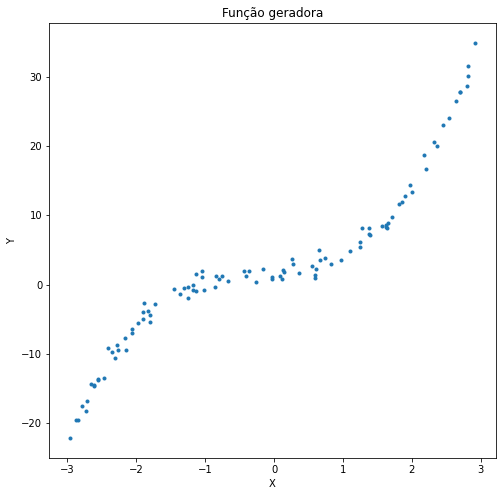

In [81]:
# Plotando as funções:
fig = plt.figure(figsize=(8, 8))
plt.plot(x, y_noisy, '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Função geradora')
plt.show()

## Definindo os conjuntos

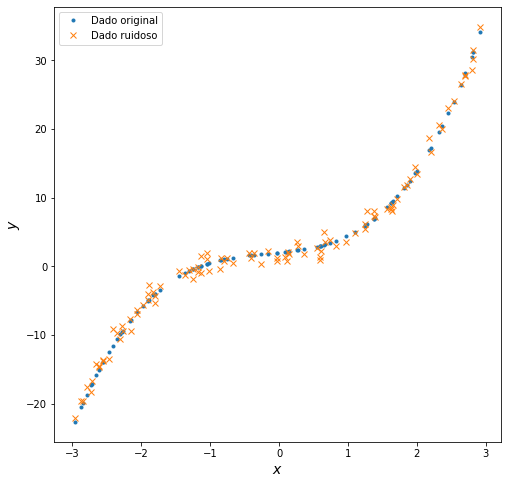

In [82]:
# Faz a plotagem da função original vs a função ruidosa
fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.show()

In [83]:
# Definindo  o número de épocas:
n_epochs = 1000

# Definindo o passo de aprendizagem:
alpha = 0.01

# Definindo a ordem do polinomio:
order = 30

# Define o tamanho do conjunto de treinamento:
size = 0.7

In [84]:
# Função de erro:
def mse(X, a, y, M):
    Jgd = (1/M)*sum(np.power((y - X.dot(a)), 2))
    return Jgd

#
def bgd(X_train, y_train, X_valid, y_valid, X_tests, y_tests, order, alpha, n_epochs, a_init):
    
    minimum_val_error = float("inf")
    
    # Armazena os melhores valores encontrados:
    best_epoch = None
    best_model = None
    
    # Cria um vetor de normalização
    norm_hist = np.zeros(n_epochs+1)
    
    # Randomiza o parâmetro de inicialização:
    a = a_init
    
    # Cria vetores para armazenamento dos valores de erro:
    jgd_train = np.zeros(n_epochs + 1)
    jgd_valid = np.zeros(n_epochs + 1)
    jgd_tests = np.zeros(n_epochs + 1)
    
    # Definindo o valor inicial para cada um dos erros
    jgd_train[0] = mse(X_train, a, y_train, len(y_train))
    jgd_valid[0] = mse(X_valid, a, y_valid, len(y_valid))
    jgd_tests[0] = mse(X_tests, a, y_tests, len(y_tests))
    
    # Definição do valor inicial de iteração:
    iter = 0
    
    # Definindo o valor inicial do erro:
    error = 1
    
    # LOOP GRADIENTE:
    while iter < n_epochs:
        
        gradients = -2/len(y_train)*X_train.T.dot(y_train - X_train.dot(a))
        
        a = a - alpha * gradients
        
        jgd_train[iter + 1] = mse(X_train, a, y_train, len(y_train))
        
        error = np.abs(jgd_train[iter + 1] - jgd_train[iter])
        
        jgd_valid[iter + 1] = mse(X_valid, a, y_valid, len(y_valid))
        jgd_tests[iter + 1] = mse(X_tests, a, y_tests, len(y_tests))
        norm_hist[iter + 1] = np.linalg.norm(a[1:])
        
        if jgd_valid[iter + 1] < minimum_val_error:
            minimum_val_error = jgd_valid[iter + 1]
            best_epoch = iter
            best_model = a
        
        iter = iter + 1
        
    return jgd_train, jgd_valid, jgd_tests, minimum_val_error, best_epoch, best_model, norm_hist, a

In [85]:
# Instancia o padronizador
scaler = StandardScaler()

# Separação dos conjuntos
x_train, x_valid, y_train, y_valid = train_test_split(x, y_noisy, test_size=size, random_state=42)

# Concatena todos os vetores para o conjunto de treinamento:
X_train = np.ones((len(y_train), 1))
for i in range(1, order + 1):
    X_train = np.c_[X_train, np.power(x_train, i)]

# Faz o escalonamento de features:
X_train = np.c_[np.ones((len(y_train),1)), scaler.fit_transform(X_train[:,1:])]

# Concatena todos os vetores para o conjunto de validação:
X_valid = np.ones((len(y_valid), 1))
for i in range(1, order + 1):
    X_valid = np.c_[X_valid, np.power(x_valid, i)]

# Faz o escalonamento das features:
X_valid = np.c_[np.ones((len(y_valid),1)), scaler.transform(X_valid[:,1:])]

# Concatena todos os vetores para o conjunto de teste:
X_tests = np.ones((len(y_tests),1))
for i in range(1, order + 1):
    X_tests = np.c_[X_tests, np.power(x_tests, i)]
    
# Faz o escalonamento das features:
X_tests = np.c_[np.ones((len(y_tests),1)), scaler.transform(X_tests[:,1:])]

# Inicializa os pesos:
a_init = np.random.randn(order + 1, 1)
if(0):
    a_init = np.zeros((order + 1, 1))
    a_init[0] = 2
    a_init[1] = 1
    a_init[2] = 0.5
    a_init[3] = 1
    
# Executa o gradiente descendente batelada:
jgd_train, jgd_valid, jgd_tests, minimum_val_error, best_epoch, best_model, norm_hist, a = bgd(X_train, y_train, X_valid, y_valid, X_tests, y_tests, order, alpha, n_epochs, a_init)


In [86]:
a_opt = [1, 0.5, 1]
# Imprime os valores encontrados:
print('best_epoch:',best_epoch)
print('minimum_val_error:',minimum_val_error)
print('norma:', np.linalg.norm(best_model[1:])/30)
print('norma:', np.linalg.norm(a_opt)/3)

best_epoch: 999
minimum_val_error: 5.8496948287672685
norma: 0.24137783323495107
norma: 0.5


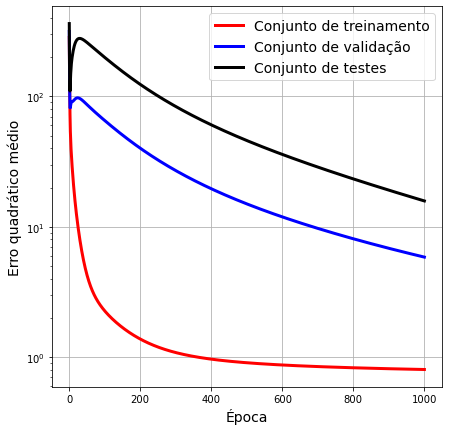

In [87]:
fig = plt.figure(figsize=(7,7))

plt.plot(range(0, n_epochs+1), jgd_train, "r-", linewidth=3, label="Conjunto de treinamento")
plt.plot(range(0, n_epochs+1), jgd_valid, "b-", linewidth=3, label="Conjunto de validação")
plt.plot(range(0, n_epochs+1), jgd_tests, "k-", linewidth=3, label="Conjunto de testes")
plt.yscale('log')
plt.legend(loc="upper right", fontsize=14)
plt.xlabel('Época', fontsize=14)
plt.ylabel("Erro quadrático médio", fontsize=14)
plt.grid()
plt.show()

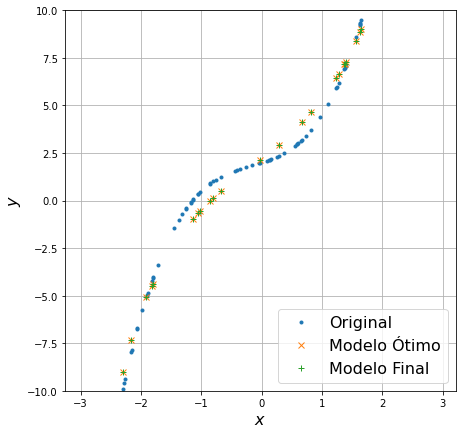

In [88]:
fig = plt.figure(figsize=(7,7))
plt.plot(x, y, '.', label='Original')
plt.plot(x_train, X_train.dot(best_model), 'x', label='Modelo Ótimo')
plt.plot(x_train, X_train.dot(a), '+', label='Modelo Final')
plt.ylim([-10, 10])
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()